## Plotting the Wigner function of $\psi(x)$

The Wigner function of $\psi(x)$ is defined: 

$W(x,p) = \frac{1}{2\pi\hbar} \int e^{-\frac{i}{\hbar}py} \psi(x+\frac{y}{2})\overline{\psi}(x-\frac{y}{2}) dy$

Since the Fourier transform of a qauntum state $\psi(x)$ is of the form:

$\tilde{\psi}(p) = \frac{1}{2\pi\hbar} \int e^{-\frac{i}{\hbar}px} \psi(x) dx$

We have that the Wigner function is simply a Fourier transform of $\psi(x+\frac{y}{2})\overline{\psi}(x-\frac{y}{2})$ in y.


The Wigner function can be rewritten via a change of variable $y \rightarrow 2y$:

$W(x,p) = \frac{1}{\pi\hbar} \int e^{-\frac{i}{\hbar}2py} \psi(x+y)\overline{\psi}(x-y) dy$

This gives us a factor of $something$ in front of the Fourier transform. (potentially $\frac{1}{2} e^{\frac{i}{\hbar}py}$ but need to check this and then add into the function)

Taking into account the same numerical considerations as before of the discrete fast Fourier transform, and the inverse fast Fourier transform we can create a method to compute and plot the Wigner function from a wavepacket $\psi(x)$.

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt, cm, colors
from scipy.fftpack import fft,ifft
from scipy.ndimage import shift

Wigner plotting function:

In [47]:
def wigner_plot(psi_x0, x, y, dx, dy, k0_ft_y, t_max, limit, xmin, xmax, ymin, ymax, elev=30, view=45, save_fig = False, frame_num = None, density = True, surface = False):
    if save_fig == True:
        assert frame_num is not None, "Please provide framenumber if saving"
        
    x, y = map(np.asarray, (x, y))
    
    #getting rid of for loops could be one way of speeding it up
    
    #setting the values of psi(x+y)
    psi_x0_plus = np.zeros((len(y),len(x)), dtype=complex)
    for i in range(len(y)):
        psi_x0_plus[i][:] = shift(psi_x0, int(-1/dy)*y[i], cval=0.0)
    
    #setting the values of psi*(x-y)
    psi_x0_minus = np.zeros((len(y),len(x)), dtype=complex)
    for i in range(len(y)):
        psi_x0_minus[i][:] = np.conjugate(shift(psi_x0, int(1/dy)*y[i], cval=0.0))
        
    #multiplying the two wavefunction together so our function is of the form psi(x+y)psi*(x-y)
    wigner_to_transform = np.multiply(psi_x0_plus,psi_x0_minus)

    #discretising the function so we can fourier transform correctly
    discrete_wigner_to_tranform = np.zeros((len(y),len(x)), dtype = complex)
    for i in range(len(y)):
        discrete_wigner_to_tranform[i][:] = wigner_to_transform[i] * np.exp(-1j * k0_ft_y * y[i]) * dy / np.sqrt(2 * np.pi)

    #fast fourier transforming
    discrete_fourier_wigner = fft(discrete_wigner_to_tranform, axis = 0)

    #un-discretising the function
    wigner = np.zeros((len(y),len(x)), dtype = complex)
    for i in range(len(y)):
        wigner[i][:] = (discrete_fourier_wigner[i] * np.exp(1j * k0_ft_y * y[i]) * np.sqrt(2 * np.pi) / dy)
     
    #checking all the values of the wigner function are real:
#     assert np.allclose(wigner.imag, 0, rtol=0, atol=1e-9), 'wigner has non-zero imaginary components' 
    
    wigner = np.real(wigner)
    
    #creating a folder for the frames
    #we will use these frames to animate
    if save_fig == True and frame_num == 0:
        try:
            os.mkdir(os.path.join(os.getcwd(),'wigner_frames'))
        except FileExistsError:
            print("Frames folder found, overwritting")
    
    #plotting:
    
    #3D surface plot
    if surface:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        y_smaller = y[int((y[-1]-1+ymin)*(1/dy)):int(-(y[-1]-ymax)*(1/dy))]
        x_smaller = x[int((x[-1]-1+xmin)*(1/dx)):int(-(x[-1]-xmax)*(1/dx))]
        X, Y = np.meshgrid(x_smaller,y_smaller)
        Z = wigner[int((y[-1]-1+ymin)*(1/dy)):int(-(y[-1]-ymax)*(1/dy)),int((x[-1]-1+xmin)*(1/dx)):int(-(x[-1]-xmax)*(1/dx))]
        ax.set_zlim3d(-limit, limit)
        ax.set_zticks(np.arange(-limit, limit+1, 5.0))
        ax.set_xlabel('q')
        ax.set_ylabel('p')
        ax.set_zlabel('W(q,p)')
        if frame_num is not None:
            if frame_num == 0:
                ax.set_title('t=%.2f' %(0))
            else:
                ax.set_title('t=%.2f' %(100*(int(frame_num)/int(t_max))))
        surf = ax.plot_surface(X,Y,Z)
    #     fig.colorbar(surf, shrink = 0.25)
        ax.view_init(elev = elev, azim = view)

        #saving the frame
        if save_fig == True:
            plt.savefig(f'wigner_frames/3d_{frame_num}', dpi=300)
            plt.clf()
            plt.close(fig)
            plt.close()
    
    #density plot
    if density:
        fig = plt.figure(figsize=(6,5))
        y_smaller = y[int((y[-1]-1+ymin)*(1/dy)):int(-(y[-1]-ymax)*(1/dy))]
        x_smaller = x[int((x[-1]-1+xmin)*(1/dx)):int(-(x[-1]-xmax)*(1/dx))]
        X, Y = np.meshgrid(x_smaller,y_smaller)
        Z = wigner[int((y[-1]-1+ymin)*(1/dy)):int(-(y[-1]-ymax)*(1/dy)),int((x[-1]-1+xmin)*(1/dx)):int(-(x[-1]-xmax)*(1/dx))]
        plt.pcolormesh(X,Y,Z, shading='auto')
        plt.clim(-limit, limit)
        cbar = plt.colorbar()
        cbar.set_label('W(q,p)')
        plt.xlabel('q')
        plt.ylabel('p', rotation = 0)
        if frame_num is not None:
            if frame_num == 0:
                plt.title('t=%.2f' %(0))
            else:
                plt.title('t=%.2f' %(100*(int(frame_num)/int(t_max))))

        #saving the frame
        if save_fig == True:
            plt.savefig(f'wigner_frames/density_{frame_num}', dpi=300)
            plt.clf()
            plt.close(fig)
            plt.close()
        else:  
            plt.show()

Setting our situation

In [29]:
#setting values of variables

hbar = 1.0 
m = 1.0 #mass

#x and y spaces
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)
dy = 0.1
y = dy * (np.arange(N) - 0.5 * N)

#potential barrier (or lack thereof)
V0 = 0.0
V_x = x*0.0
V_x[x < -98] = 1E6
V_x[x > 98] = 1E6


p0 = 0.0
#initial momentum
d = 5
#input for width of intial wave
k0 = p0 / hbar
#intial wavenumber
v0 = p0 / m
#intial velocity
k0_ft_y = -np.pi / dy
#value in the discrete version of wave
x0 = 0.0
#centre of wave

t_max = 200

xmin = -45
xmax = 45
#the wave:

def gauss_x(x, a, x0, k0):
#wave with width a, centred at x0 with momentum k0
  return ((a * np.sqrt(np.pi)) ** (-0.5) * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))

psi_x0 = gauss_x(x, d, x0, k0)

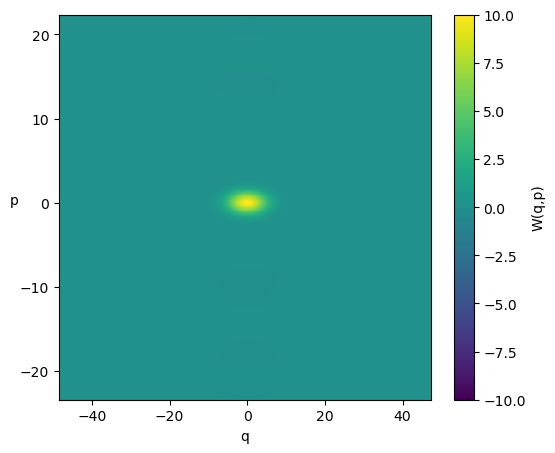

In [49]:
wigner_plot(psi_x0 = psi_x0, x=x, dx=dx, y=y, dy=dy, k0_ft_y=k0_ft_y, t_max=t_max, view=230, limit=10, xmin=xmin, xmax=xmax, save_fig = False, frame_num = None)

In [246]:
#the next thing to go for would be to make the resolution smaller on x and k so it looks a bit smoother
#or alternatively figure out another way to smooth / interpolate it